In [9]:
# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].values
class MyLabelEncoder(LabelEncoder):
    def fit(self, X, y=None):
        super(MyLabelEncoder, self).fit(X)
    def transform(self, X, y=None):
        return super(MyLabelEncoder, self).transform(X)
    def fit_transform(self, X, y=None):
        tmp = super(MyLabelEncoder, self).fit(X).transform(X)
        return tmp.reshape(len(tmp), 1)

In [10]:
# Read the data
statcast_df = pd.read_csv('Data/Statcast_2020.csv')
batters_df = pd.read_csv('Data/batters_2019.csv')

In [11]:
statcast_df.columns

Index(['Unnamed: 0', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       'events', 'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',


In [12]:
batters_df.head()

,last_name,first_name,player_id,year,xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,Unnamed: 12
0,Pujols,Albert,405395,2019,0.247,0.422,0.315,0.310,0.175,88.3,12.5,5.8,NaN
1,Cabrera,Miguel,408234,2019,0.266,0.433,0.328,0.334,0.167,90.4,12.3,6.7,NaN
2,Choo,Shin-Soo,425783,2019,0.262,0.476,0.362,0.369,0.214,91.9,9.1,9.0,NaN
3,Jones,Adam,430945,2019,0.256,0.430,0.318,0.311,0.174,86.1,13.4,6.7,NaN
4,Cruz Jr.,Nelson,443558,2019,0.290,0.638,0.416,0.378,0.348,93.7,13.1,19.9,NaN


In [13]:
# Find unique elements of array
statcast_df.description.unique()

array(['hit_into_play', 'ball', 'called_strike', 'foul',
       'swinging_strike', 'foul_tip', 'blocked_ball', 'hit_by_pitch',
       'swinging_strike_blocked', 'foul_bunt', 'missed_bunt', 'pitchout',
       'bunt_foul_tip'], dtype=object)

In [14]:
# Save import columns
statcast_df = statcast_df[['inning', 'inning_topbot', 'outs_when_up', 'balls', 'strikes', 'stand', 
 'p_throws', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 
 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'description']]

statcast_df.head()

,inning,inning_topbot,outs_when_up,balls,strikes,stand,p_throws,effective_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,description
0,9,Top,2,1,0,L,R,100.2,2483.0,198.0,-0.15,1.64,1.07,2.00,3.16,1.48,hit_into_play
1,9,Top,2,0,0,L,R,100.0,2522.0,189.0,0.06,1.72,1.61,3.72,3.09,1.37,ball
2,9,Top,1,3,2,R,R,90.8,2537.0,58.0,0.33,-0.45,0.24,2.56,3.20,1.55,called_strike
3,9,Top,1,3,1,R,R,101.7,2469.0,191.0,-0.27,1.55,0.37,2.35,3.42,1.58,foul
4,9,Top,1,3,0,R,R,98.9,2339.0,191.0,-0.23,1.57,0.11,3.67,3.42,1.58,swinging_strike


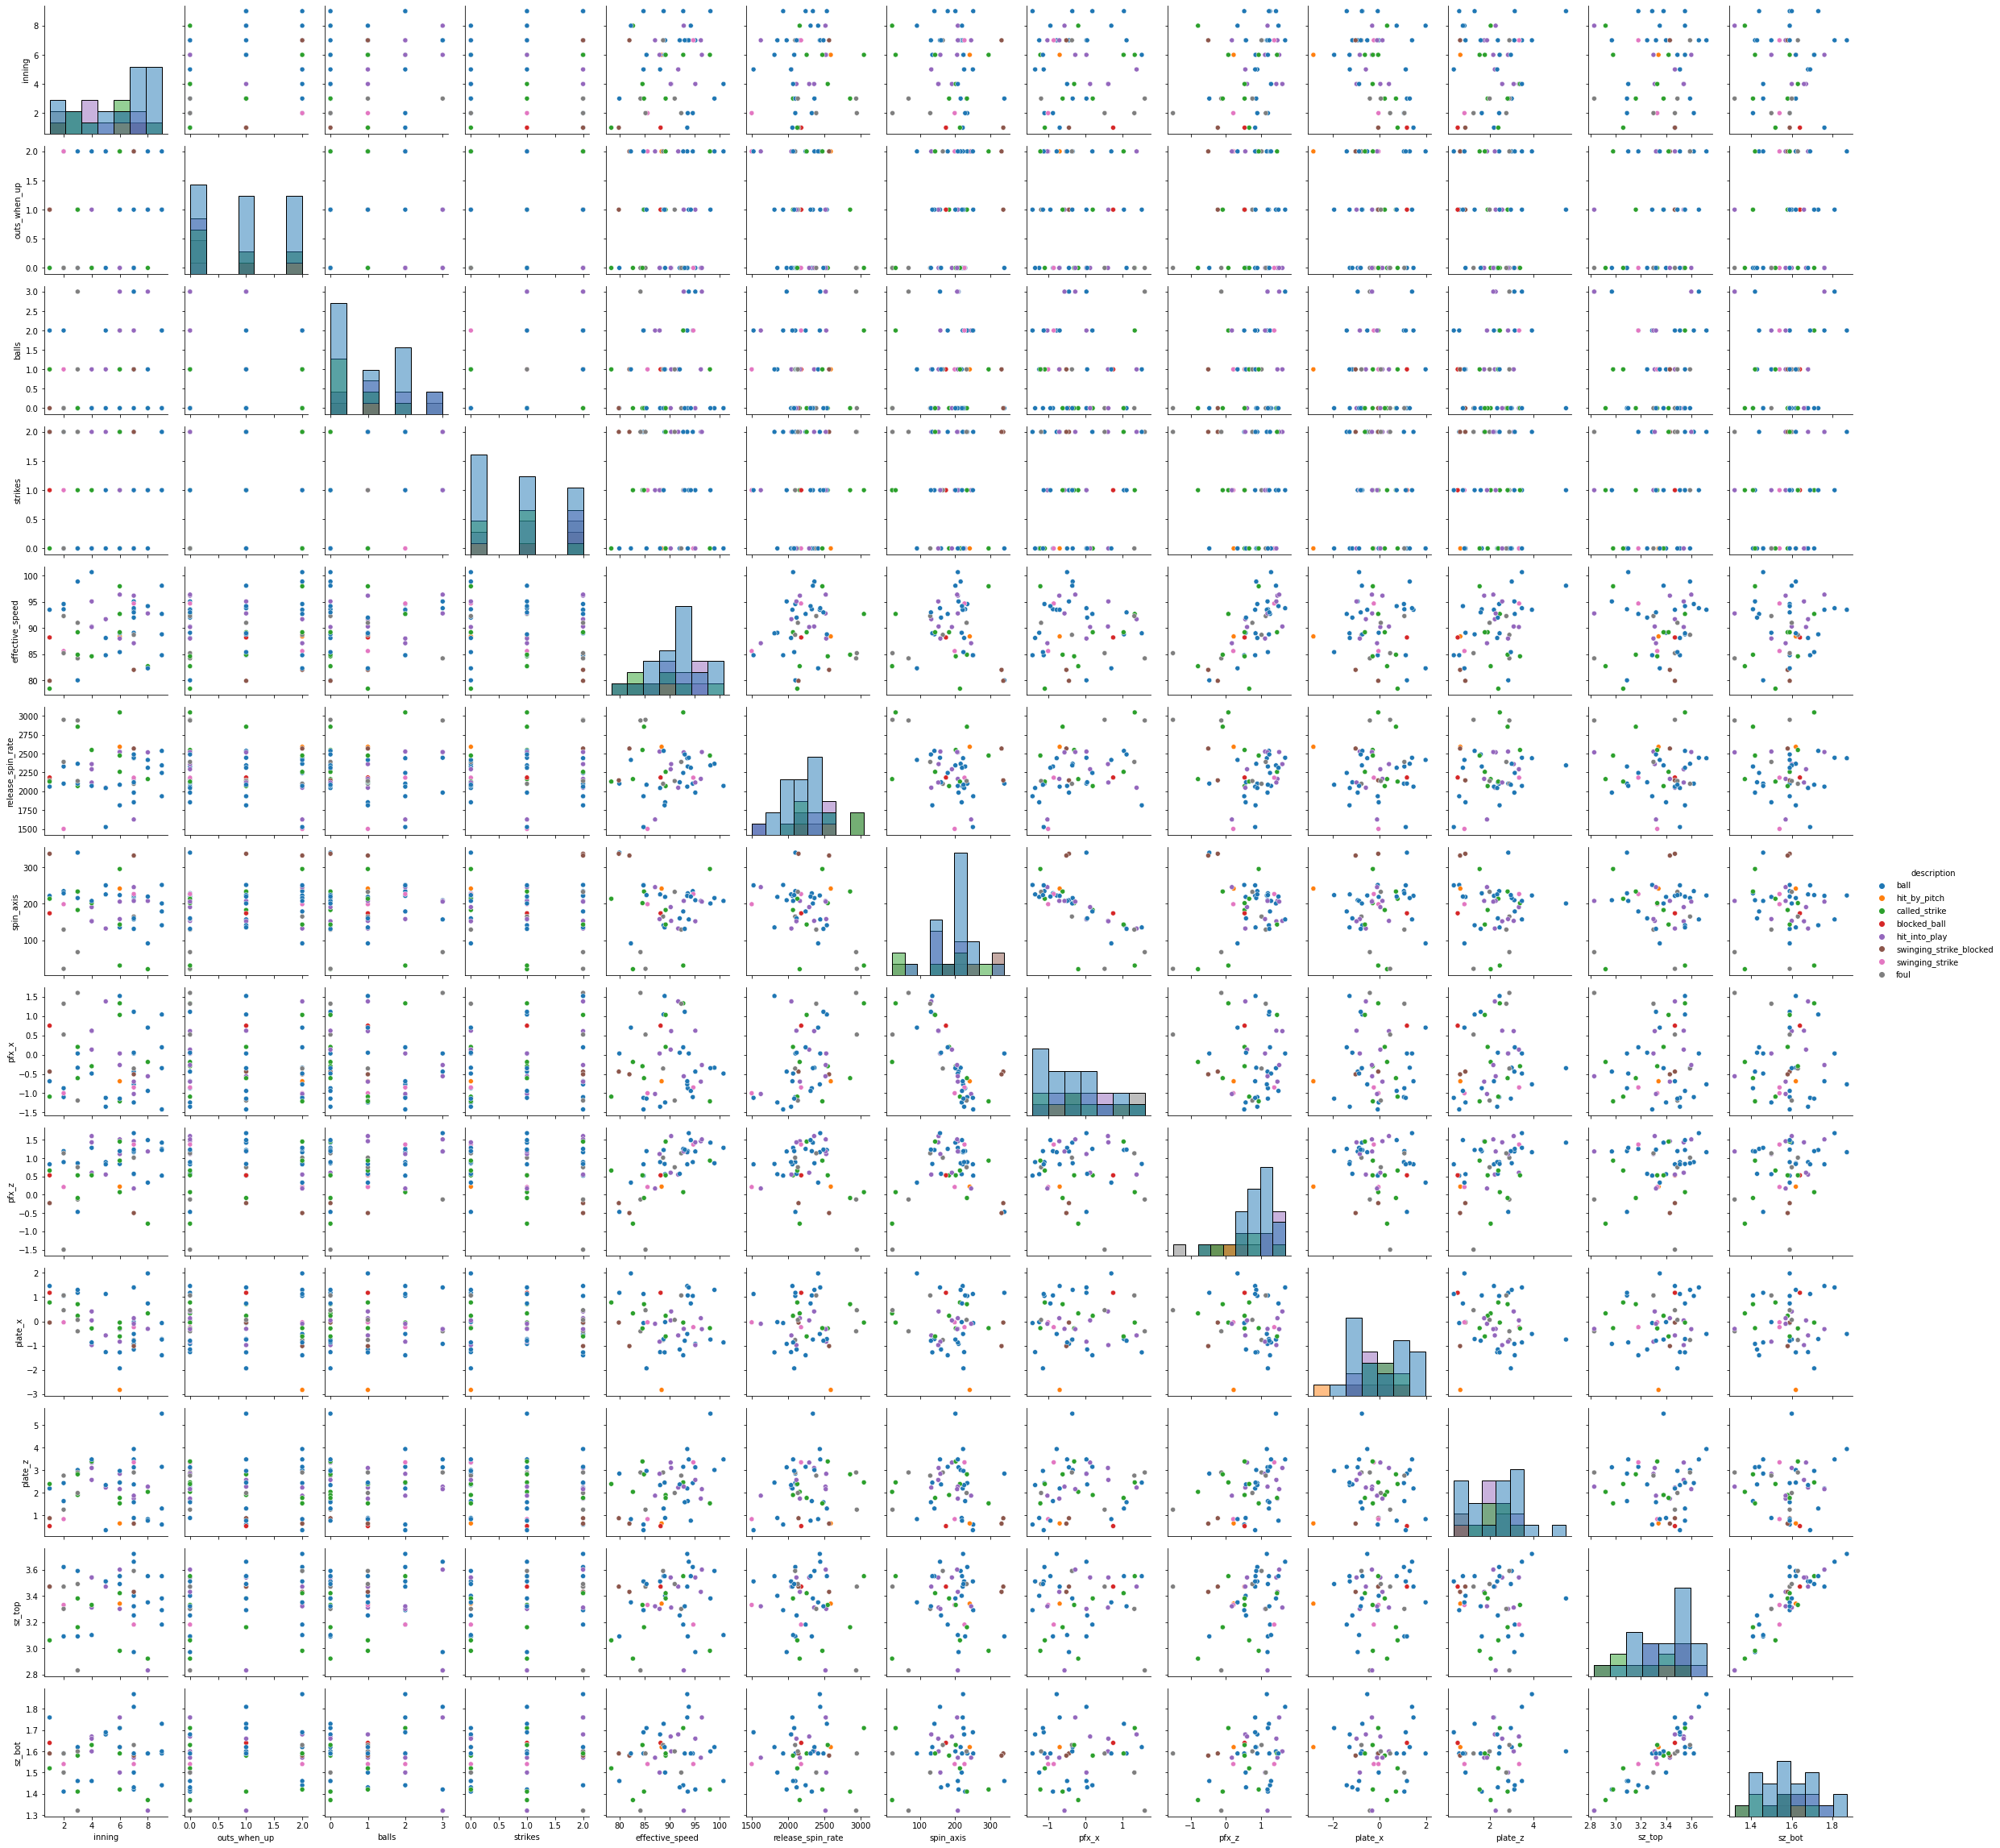

In [17]:
# Label the data
numerical = ['inning', 'outs_when_up', 'balls', 'strikes', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']
categorical = ['inning_topbot']

# Remove nulls
statcast_df = statcast_df.dropna()

# Plot pairwise relationships in the dataset
g = sns.PairGrid(statcast_df.sample(n=50), hue='description')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [19]:
X = statcast_df.iloc[:, :-1]
y = statcast_df.iloc[:, -1]
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X, y, test_size=0.3, shuffle=True)
le = LabelEncoder()

In [20]:
# Chain the estimators into one
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical)),
    ('label_encoder', MyLabelEncoder()),
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

X_train_pre

,inning,inning_topbot,outs_when_up,balls,strikes,stand,p_throws,effective_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot
212701,8,Bot,0,1,1,R,R,78.3,2218.0,58.0,0.77,0.10,0.14,3.03,3.47,1.59
137335,6,Bot,0,1,0,L,R,92.9,2385.0,218.0,-0.76,1.38,-0.39,2.66,3.25,1.51
211350,5,Bot,2,0,0,R,L,80.0,2284.0,284.0,-0.18,-0.04,0.11,1.42,3.30,1.50
11517,6,Top,0,0,0,R,L,93.2,2321.0,134.0,0.89,1.48,0.47,3.16,3.46,1.59
205157,3,Bot,0,0,0,R,R,87.0,2123.0,202.0,0.01,0.45,1.20,1.82,3.42,1.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146876,5,Top,0,1,1,R,R,86.2,2372.0,91.0,0.26,-0.30,0.32,1.92,3.35,1.59
23065,7,Bot,0,1,0,L,R,77.7,1777.0,53.0,0.35,-0.46,-0.50,1.06,3.37,1.64
144941,8,Bot,2,0,0,L,L,76.5,2053.0,330.0,-0.35,-0.57,-0.15,2.53,3.33,1.58
177253,3,Bot,0,3,2,R,R,85.3,2255.0,202.0,0.26,0.57,0.31,2.31,3.55,1.63
